In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
# ============================================================
# Symmetric stress tests:
#   (Left)  TSR vs buyer reserve multiplier (×R)
#            → SupplyFirst, BrokerCentric, TripleWin
#   (Right) TSR vs buyer overhead multiplier (×κ_M)
#            → DemandFirst, BrokerCentric, TripleWin
# ============================================================

import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# ---- Add src directory if needed ----
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

# ---- Import pricing mechanisms ----
from pricing.supply_first import SupplyFirstPricing
from pricing.demand_first import DemandFirstPricing
from pricing.broker_centric import BrokerCentricPricingRobust
from pricing.triple_win import TripleWinPricing


In [ ]:
df_shapley = pd.read_csv("../tables/unified_shapley_matrix_10sellers.csv")

selected_columns = []

MODELS_NUM = 10

for i in range(10):
    selected_columns.append(f"seller_{i}")
SV = df_shapley[selected_columns].sample(MODELS_NUM).values.transpose()
SV = SV / SV.sum(axis=0, keepdims=True)

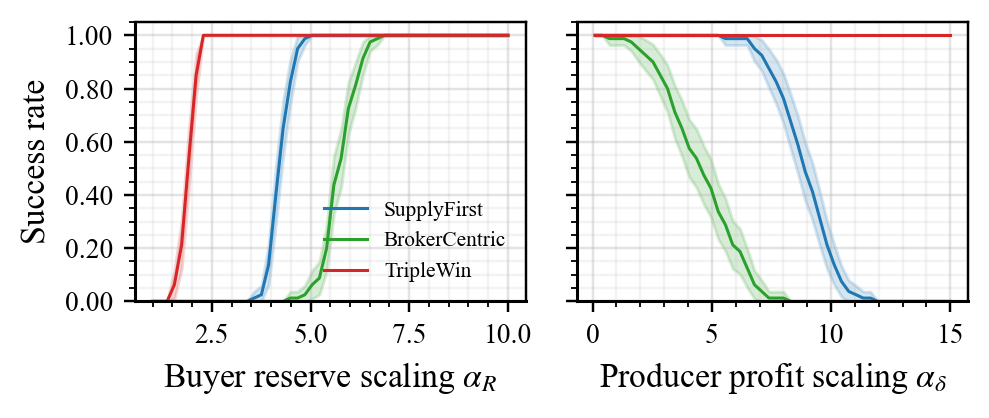

In [8]:
# ============================================================
# Global style
# ============================================================
mpl.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 600,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 7,
})

method_colors = {
    "SupplyFirst":   plt.cm.tab10(0),  # blue
    "DemandFirst":   plt.cm.tab10(1),  # orange
    "BrokerCentric": plt.cm.tab10(2),  # green
    "TripleWin":     plt.cm.tab10(3),  # red
}

# ============================================================
# Utilities
# ============================================================
class BuyerBlock:
    def __init__(self, kappa_mb, R, omega, p_init=None):
        self.kappa_mb = np.asarray(kappa_mb, dtype=float)
        self.R        = np.asarray(R, dtype=float)
        self.omega    = np.asarray(omega, dtype=float)
        self.p_init   = None if p_init is None else np.asarray(p_init, dtype=float)
        self.p0       = self.kappa_mb

def make_random_market(rng, SV,
                       sv_low=0.02, sv_high=0.20,
                       kappaD_low=0.10, kappaD_high=0.40,
                       kappaM_low=1.0, kappaM_high=5.0,
                       R_low=8.0, R_high=16.0,
                       rho_sum=0.6,
                       buyers_per_model=(2,5),
                       delta_val=0.10):
    I, J = SV.shape

    delta = np.full(J, float(delta_val), dtype=float)
    kappa_D_vec = rng.uniform(kappaD_low, kappaD_high, size=I)
    bar_p_DtoM  = rng.uniform(1.5, 4.0, size=(I, J))
    p_DtoM_init = bar_p_DtoM.copy()

    buyers = []
    for j in range(J):
        K_j = rng.integers(buyers_per_model[0], buyers_per_model[1] + 1)
        kappa_mb = rng.uniform(kappaM_low, kappaM_high, size=K_j)
        R        = rng.uniform(R_low, R_high, size=K_j)
        omega    = np.full(K_j, rho_sum / K_j)
        buyers.append(BuyerBlock(kappa_mb, R, omega))
    return SV, delta, kappa_D_vec, bar_p_DtoM, buyers, p_DtoM_init

def clone_scale_buyers(buyers, alpha_R=1.0, alpha_kM=1.0):
    out = []
    for blk in buyers:
        new_blk = BuyerBlock(
            kappa_mb=alpha_kM * blk.kappa_mb,
            R=alpha_R * blk.R,
            omega=blk.omega.copy(),
            p_init=None if blk.p_init is None else alpha_kM * blk.p_init
        )
        out.append(new_blk)
    return out

def build_bounds_vec(buyers, kappa_D_vec, J):
    lowers, uppers = [], []
    for blk in buyers:
        K = blk.R.size
        lowers.append(np.full(K, -np.inf))
        uppers.append(blk.R.flatten())
    I = kappa_D_vec.size
    lowers.append(np.repeat(kappa_D_vec, J))
    uppers.append(np.full(I * J, np.inf))
    lb = np.concatenate(lowers)
    ub = np.concatenate(uppers)
    return lb, ub

def solve_and_global_success(method_cls, SV, delta, kappa_D_vec, buyers, bar_p_DtoM, p_DtoM_init,
                             tol=1e-10, max_iter=500):
    solver = method_cls(
        shapley_values=SV, delta=delta, kappa_D=kappa_D_vec, buyers=buyers,
        C_var=kappa_D_vec, bar_p_DtoM=bar_p_DtoM, p_DtoM_init=p_DtoM_init,
        tol=tol, max_iter=max_iter, verbose=False
    )
    out = solver.fit()
    lb, ub = build_bounds_vec(buyers, kappa_D_vec, J=SV.shape[1])
    p_concat = np.concatenate([p.flatten() for p in solver.p_MtoB] + [solver.p_DtoM.flatten()])
    ok = np.all((p_concat >= lb) & (p_concat <= ub))
    return int(bool(ok))


# ============================================================
# One-row-two-columns: (Left) TSR vs reserve scaling α_R (no DemandFirst)
#                      (Right) TSR vs profit scaling α_δ
# ============================================================

# --- Difficulty grids ---
alpha_R_grid   = np.linspace(1.0, 10.0, 50)  # larger = easier
alpha_del_grid = np.linspace(0.1, 15.0, 50)  # larger = harder

# --- Monte Carlo settings (reuse from above if you like) ---
N_TRIALS = 80
I, J = SV.shape
R_base_min, R_base_max = 8.0, 16.0
DELTA_BASE = 0.10
RHO  = 0.6
rng = np.random.default_rng(2025)

# --- Methods to plot (DemandFirst removed per request) ---
methods_plot = {
    "SupplyFirst":   SupplyFirstPricing,
    "BrokerCentric": BrokerCentricPricingRobust,
    "TripleWin":     TripleWinPricing,
}

# ---------- LEFT PANEL: TSR vs α_R (reserve scaling) ----------
tsr_sum_R = {name: np.zeros_like(alpha_R_grid, dtype=float) for name in methods_plot}

for t in range(N_TRIALS):
    # Build one base market; then only scale R inside the α_R loop (paired comparison).
    SV, delta_base, kappa_D_vec, bar_p_DtoM, buyers_base, p_DtoM_init = make_random_market(
        rng, SV=SV, R_low=R_base_min, R_high=R_base_max, rho_sum=RHO, delta_val=DELTA_BASE
    )
    for idx, aR in enumerate(alpha_R_grid):
        buyers_scaled = clone_scale_buyers(buyers_base, alpha_R=aR, alpha_kM=1.0)
        for name, cls in methods_plot.items():
            ok = solve_and_global_success(
                cls, SV, delta_base, kappa_D_vec, buyers_scaled, bar_p_DtoM, p_DtoM_init,
                tol=1e-10, max_iter=500
            )
            tsr_sum_R[name][idx] += ok

tsr_mean_R = {name: tsr_sum_R[name] / N_TRIALS for name in methods_plot}
tsr_ci_R   = {name: 1.96 * np.sqrt(tsr_mean_R[name] * (1 - tsr_mean_R[name]) / N_TRIALS)
              for name in methods_plot}

# ---------- RIGHT PANEL: TSR vs α_δ (profit scaling on margins) ----------
# We scale producer margins: delta_scaled = α_δ * delta_base
tsr_sum_del = {name: np.zeros_like(alpha_del_grid, dtype=float) for name in methods_plot}

for t in range(N_TRIALS):
    # Build one base market; then only scale δ inside the α_δ loop (paired comparison).
    SV, delta_base, kappa_D_vec, bar_p_DtoM, buyers_base, p_DtoM_init = make_random_market(
        rng, SV=SV, R_low=R_base_min*7, R_high=R_base_max*7, rho_sum=RHO, delta_val=DELTA_BASE
    )
    for idx, aDel in enumerate(alpha_del_grid):
        delta_scaled = aDel * delta_base
        # Buyers not rescaled in this experiment; κ_M and R unchanged
        for name, cls in methods_plot.items():
            ok = solve_and_global_success(
                cls, SV, delta_scaled, kappa_D_vec, buyers_base, bar_p_DtoM, p_DtoM_init,
                tol=1e-10, max_iter=500
            )
            tsr_sum_del[name][idx] += ok

tsr_mean_del = {name: tsr_sum_del[name] / N_TRIALS for name in methods_plot}
tsr_ci_del   = {name: 1.96 * np.sqrt(tsr_mean_del[name] * (1 - tsr_mean_del[name]) / N_TRIALS)
                for name in methods_plot}

# ---------- Plot: one row × two columns ----------
fig, axes = plt.subplots(1, 2, figsize=(4.6, 2.0), sharey=True)

# Left: TSR vs α_R
ax = axes[0]
for name in ["SupplyFirst", "BrokerCentric", "TripleWin"]:
    m = tsr_mean_R[name]; e = tsr_ci_R[name]
    ax.plot(alpha_R_grid, m, label=name, color=method_colors[name], linewidth=1.0)
    ax.fill_between(alpha_R_grid, np.clip(m - e, 0, 1), np.clip(m + e, 0, 1),
                    alpha=0.18, color=method_colors[name])
ax.set_xlabel(r"Buyer reserve scaling $\alpha_R$")
ax.set_ylabel("Success rate")
ax.set_ylim(0.0, 1.05)
ax.set_yticks(np.linspace(0, 1.0, 6)); ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax.grid(True, which="major", alpha=0.35); ax.grid(True, which="minor", alpha=0.15); ax.minorticks_on()
for s in ("top","right"): ax.spines[s].set_visible(True)
for s in ("left","bottom"): ax.spines[s].set_linewidth(1.0)
ax.legend(frameon=False, loc="lower right")

# Right: TSR vs α_δ
ax = axes[1]
for name in ["SupplyFirst", "BrokerCentric", "TripleWin"]:
    m = tsr_mean_del[name]; e = tsr_ci_del[name]
    ax.plot(alpha_del_grid, m, label=name, color=method_colors[name], linewidth=1.0)
    ax.fill_between(alpha_del_grid, np.clip(m - e, 0, 1), np.clip(m + e, 0, 1),
                    alpha=0.18, color=method_colors[name])
ax.set_xlabel(r"Producer profit scaling $\alpha_{\delta}$")
ax.set_ylim(0.0, 1.05)
ax.set_yticks(np.linspace(0, 1.0, 6)); ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax.grid(True, which="major", alpha=0.35); ax.grid(True, which="minor", alpha=0.15); ax.minorticks_on()
for s in ("top","right"): ax.spines[s].set_visible(True)
for s in ("left","bottom"): ax.spines[s].set_linewidth(1.0)

fig.tight_layout()
fig.savefig("../plots/success_rate.pdf", format="pdf", bbox_inches="tight")
plt.show()

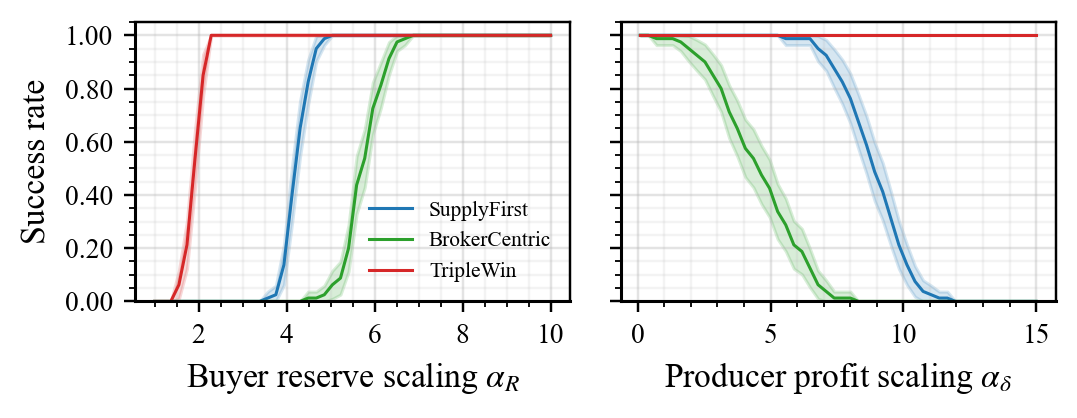

In [9]:
# ---------- Plot: one row × two columns ----------
fig, axes = plt.subplots(1, 2, figsize=(5, 2.0), sharey=True)

# Left: TSR vs α_R
ax = axes[0]
for name in ["SupplyFirst", "BrokerCentric", "TripleWin"]:
    m = tsr_mean_R[name]; e = tsr_ci_R[name]
    ax.plot(alpha_R_grid, m, label=name, color=method_colors[name], linewidth=1.0)
    ax.fill_between(alpha_R_grid, np.clip(m - e, 0, 1), np.clip(m + e, 0, 1),
                    alpha=0.18, color=method_colors[name])
ax.set_xlabel(r"Buyer reserve scaling $\alpha_R$")
ax.set_ylabel("Success rate")
ax.set_ylim(0.0, 1.05)
ax.set_yticks(np.linspace(0, 1.0, 6)); ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax.grid(True, which="major", alpha=0.35); ax.grid(True, which="minor", alpha=0.15); ax.minorticks_on()
for s in ("top","right"): ax.spines[s].set_visible(True)
for s in ("left","bottom"): ax.spines[s].set_linewidth(1.0)
ax.legend(frameon=False, loc="lower right")

# Right: TSR vs α_δ
ax = axes[1]
for name in ["SupplyFirst", "BrokerCentric", "TripleWin"]:
    m = tsr_mean_del[name]; e = tsr_ci_del[name]
    ax.plot(alpha_del_grid, m, label=name, color=method_colors[name], linewidth=1.0)
    ax.fill_between(alpha_del_grid, np.clip(m - e, 0, 1), np.clip(m + e, 0, 1),
                    alpha=0.18, color=method_colors[name])
ax.set_xlabel(r"Producer profit scaling $\alpha_{\delta}$")
ax.set_ylim(0.0, 1.05)
ax.set_yticks(np.linspace(0, 1.0, 6)); ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax.grid(True, which="major", alpha=0.35); ax.grid(True, which="minor", alpha=0.15); ax.minorticks_on()
for s in ("top","right"): ax.spines[s].set_visible(True)
for s in ("left","bottom"): ax.spines[s].set_linewidth(1.0)

fig.tight_layout()
fig.savefig("../plots/success_rate.pdf", format="pdf", bbox_inches="tight")
plt.show()